In [3]:
# 기본 라이브러리
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt

# 딥러닝 라이브러리
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image

In [4]:
# 경로 설정
dataset_dir = r'D:/GitHub/CNN_Model/dataset'
original_dataset_dir = os.path.join(dataset_dir, 'training_set')
validation_dir = os.path.join(dataset_dir, 'validation_set')

# 서브 디렉토리 설정
train_cats_dir = os.path.join(original_dataset_dir, 'cats')
train_dogs_dir = os.path.join(original_dataset_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# validation 디렉토리 생성
os.makedirs(validation_cats_dir, exist_ok=True)
os.makedirs(validation_dogs_dir, exist_ok=True)

# validation에 사용할 이미지 수
num_val = 1000

# 파일 리스트
cat_fnames = [f for f in os.listdir(train_cats_dir)]
dog_fnames = [f for f in os.listdir(train_dogs_dir)]

random.seed(42)
random.shuffle(cat_fnames)
random.shuffle(dog_fnames)

# 고양이 validation 복사
for i, fname in enumerate(cat_fnames):
    if i < num_val:
        src = os.path.join(train_cats_dir, fname)
        dst = os.path.join(validation_cats_dir, fname)
        shutil.copyfile(src, dst)

# 강아지 validation 복사
for i, fname in enumerate(dog_fnames):
    if i < num_val:
        src = os.path.join(train_dogs_dir, fname)
        dst = os.path.join(validation_dogs_dir, fname)
        shutil.copyfile(src, dst)

print('validation_set 생성 완료!')


validation_set 생성 완료!


In [5]:
# Generator 설정
train_dir = os.path.join(dataset_dir, 'training_set')
validation_dir = os.path.join(dataset_dir, 'validation_set')
test_dir = os.path.join(dataset_dir, 'test_set')

# 강화된 Data Augmentation 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# 제너레이터 생성
batch_size = 32
image_size = (150, 150)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 8005 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
# VGG16 base model 불러오기
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

# VGG16 base 고정
conv_base.trainable = False

# 구조 확인 (선택사항)
conv_base.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
# Transfer Learning용 모델 구성
model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [8]:
# 컴파일
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

# 구조 확인
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# 학습
epochs = 50

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

C:\Users\junju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6976 - loss: 0.5804

C:\Users\junju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 995s 4s/step - accuracy: 0.6978 - loss: 0.5800 - val_accuracy: 0.8841 - val_loss: 0.2846
Epoch 2/50
  1/250 ━━━━━━━━━━━━━━━━━━━━ 11:45 3s/step - accuracy: 0.8125 - loss: 0.4795

C:\Users\junju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


250/250 ━━━━━━━━━━━━━━━━━━━━ 179s 709ms/step - accuracy: 0.8125 - loss: 0.4795 - val_accuracy: 0.8816 - val_loss: 0.2802
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 963s 4s/step - accuracy: 0.8102 - loss: 0.3991 - val_accuracy: 0.8886 - val_loss: 0.2657
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 216s 854ms/step - accuracy: 0.8750 - loss: 0.2961 - val_accuracy: 0.8911 - val_loss: 0.2616
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 933s 4s/step - accuracy: 0.8241 - loss: 0.3772 - val_accuracy: 0.8982 - val_loss: 0.2514
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 156s 616ms/step - accuracy: 0.8125 - loss: 0.4049 - val_accuracy: 0.8841 - val_loss: 0.2647
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 727s 3s/step - accuracy: 0.8412 - loss: 0.3604 - val_accuracy: 0.8931 - val_loss: 0.2445
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 145s 571ms/step - accuracy: 0.8750 - loss: 0.3605 - val_accuracy: 0.9047 - val_loss: 0.2467
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 754s 3s/step - accuracy: 0.8437 - loss: 0.3496 - val_acc

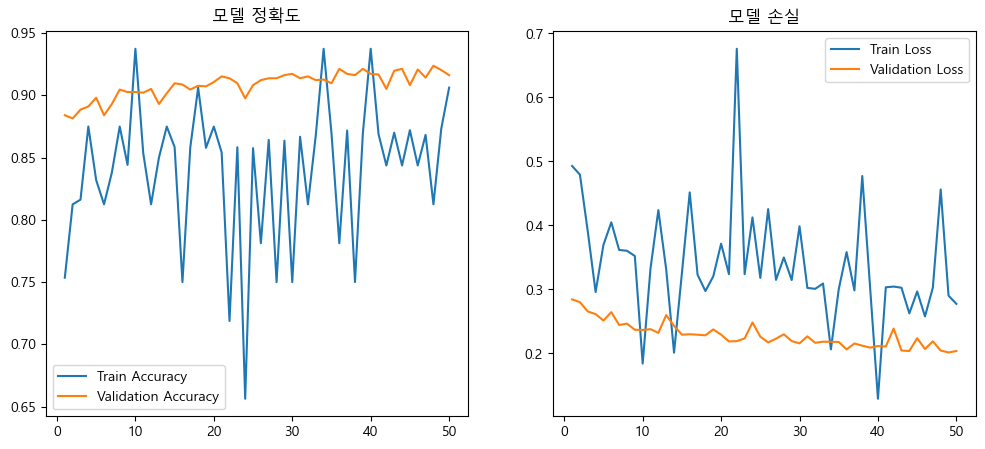

최종 검증 정확도: 0.9163, 최종 검증 손실: 0.2039


In [12]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, epochs + 1)
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕
fontprop = fm.FontProperties(fname=font_path, size=14)
plt.rc('font', family=fontprop.get_name())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('모델 정확도')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('모델 손실')
plt.legend()

plt.show()

# 최종 성능 출력
final_val_acc = val_acc[-1]
final_val_loss = val_loss[-1]
print(f"최종 검증 정확도: {final_val_acc:.4f}, 최종 검증 손실: {final_val_loss:.4f}")

In [11]:
# 테스트할 이미지 경로
test_image_path = r'D:/GitHub/CNN_Model/example/cat.jpg'  # 예시

img = image.load_img(test_image_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

if prediction < 0.5:
    print(f"모델 예측: 고양이 (확률: {1 - prediction[0][0]:.4f})")
else:
    print(f"모델 예측: 강아지 (확률: {prediction[0][0]:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
모델 예측: 고양이 (확률: 0.9952)
